## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images
* Sample Check
* Read Images and Prepare Objectpoint Array

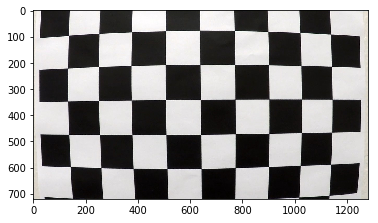

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import random
import matplotlib.image as mpimg
%matplotlib inline


img = mpimg.imread('./camera_cal/calibration1.jpg')
plt.imshow(img)

In [2]:
# 
def detect_corners(nx, ny, images):
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((ny * nx, 3), np.float32)
    objp[:, : 2] = np.mgrid[0 : nx, 0 : ny].T.reshape(-1, 2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.
    
    # Step through the list and search for chessboard corners
    for img in images:
        # Converrt to Grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
            
    return objpoints, imgpoints


def cal_undistort(img, objpoints, imgpoints):
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[:2],None,None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    #undist = np.copy(img)  # Delete this line
    return undist


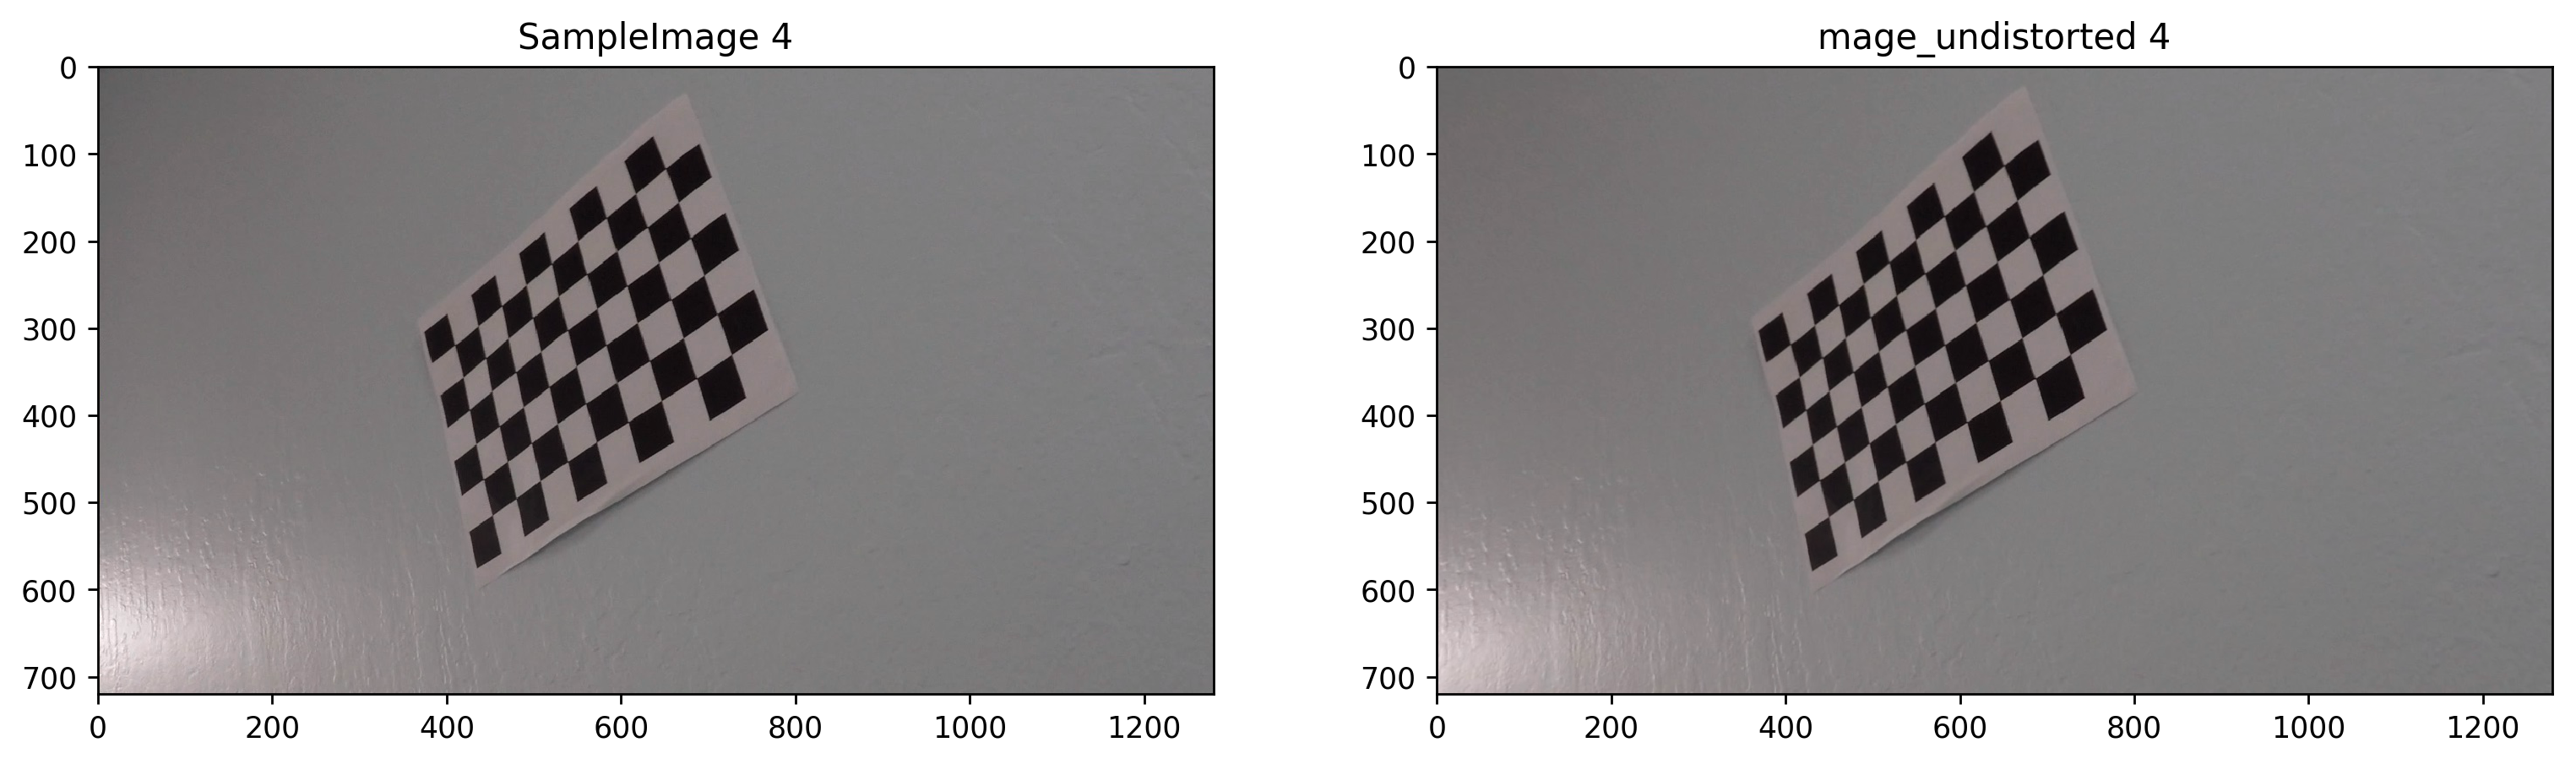

In [3]:
nx = 9
ny = 6

# Prepare Images
imagefiles = glob.glob('./camera_cal/calibration*.jpg')
images = []
for fname in imagefiles:
    img = cv2.imread(fname)
    images.append(img)

objpoints, imgpoints = detect_corners(nx, ny, images)

# Select Sample
index = random.randint(0, len(images) - 1)
img = images[index]
undistorted = cal_undistort(img, objpoints, imgpoints)


plt.figure(figsize=(15,7), dpi=250)
plt.subplot(1,2, 1)
plt.title('SampleImage ' + str(index)) 
plt.imshow(img)

# Show Undistorted
plt.subplot(1,2, 2)
plt.title('mage_undistorted ' + str(index)) 
plt.imshow(undistorted)

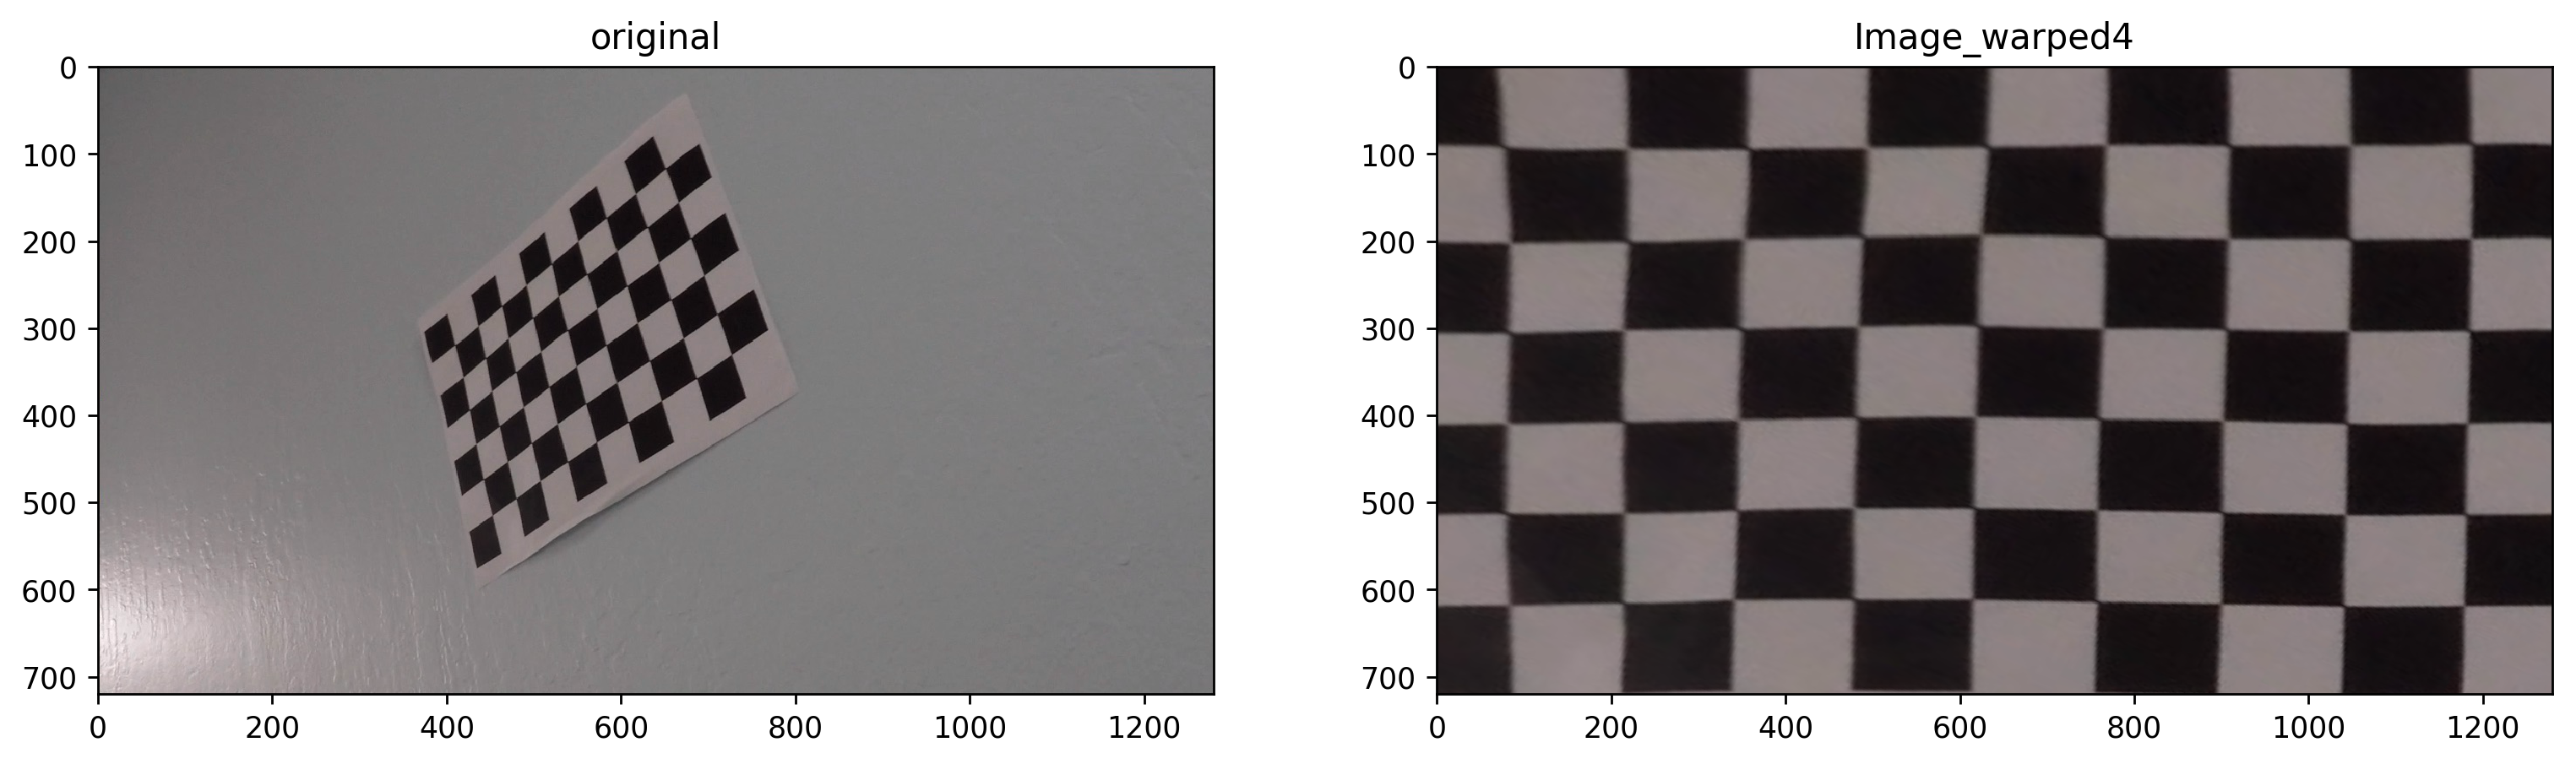

In [4]:
# 
img_size = (img.shape[1], img.shape[0])
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
if ret == True:
    undistorted = cal_undistort(img, objpoints, imgpoints)
    offset = 100
    src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
    dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                                 [img_size[0]-offset, img_size[1]-offset], 
                                 [offset, img_size[1]-offset]])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(undistorted, M, img_size, flags=cv2.INTER_LINEAR)


# Show Warped
plt.figure(figsize=(15,7), dpi=250)
plt.subplot(1,2, 1)
plt.imshow(img)
plt.title('original')
plt.subplot(1,2, 2)
plt.title('Image_warped' + str(index)) 
plt.imshow(warped)

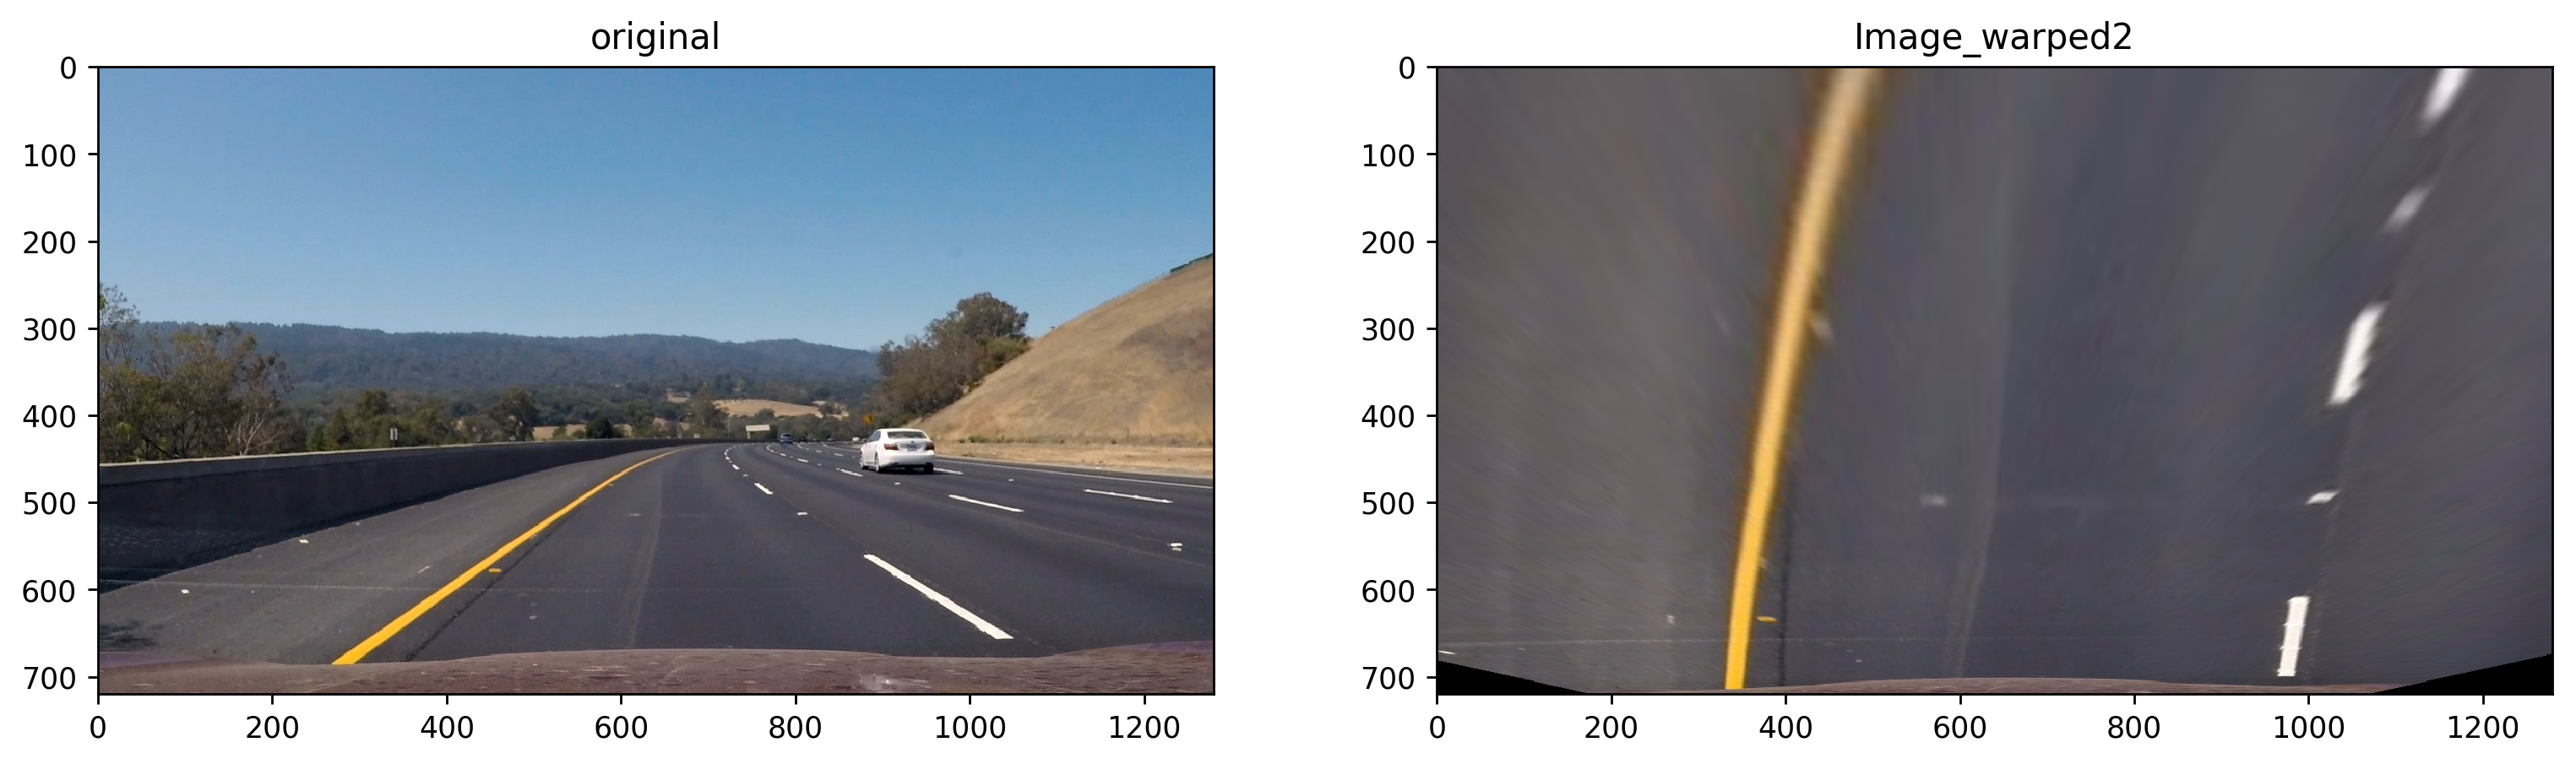

In [39]:

offset = 100    
src = np.float32(
[[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
[((img_size[0] / 6) - 10), img_size[1]],
[(img_size[0] * 5 / 6) + 60, img_size[1]],
[(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
dst = np.float32(
[[(img_size[0] / 4), 0],
[(img_size[0] / 4), img_size[1]],
[(img_size[0] * 3 / 4), img_size[1]],
[(img_size[0] * 3 / 4), 0]])
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[:2],None,None)
 
# Prepare Images
def warper(img, nx, ny):
    img_size = (img.shape[1], img.shape[0])
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    undistorted = cv2.undistort(img, mtx, dist, None, mtx)
    warped = cv2.warpPerspective(undistorted, M, img_size, flags=cv2.INTER_LINEAR)

    return warped


imagefiles = glob.glob('./test_images/test*.jpg')
images = []
for fname in imagefiles:
    img = mpimg.imread(fname)
    images.append(img)

# Select Sample
index = random.randint(0, len(images) - 1)
img = images[index]

warped = warper(img, nx, ny)

if warped.any():
    # Show Warped
    plt.figure(figsize=(15,7), dpi=250)
    plt.subplot(1,2, 1)
    plt.imshow(img)
    plt.title('original')
    plt.subplot(1,2, 2)
    plt.title('Image_warped' + str(index)) 
    plt.imshow(warped)

## Next, Thresholding

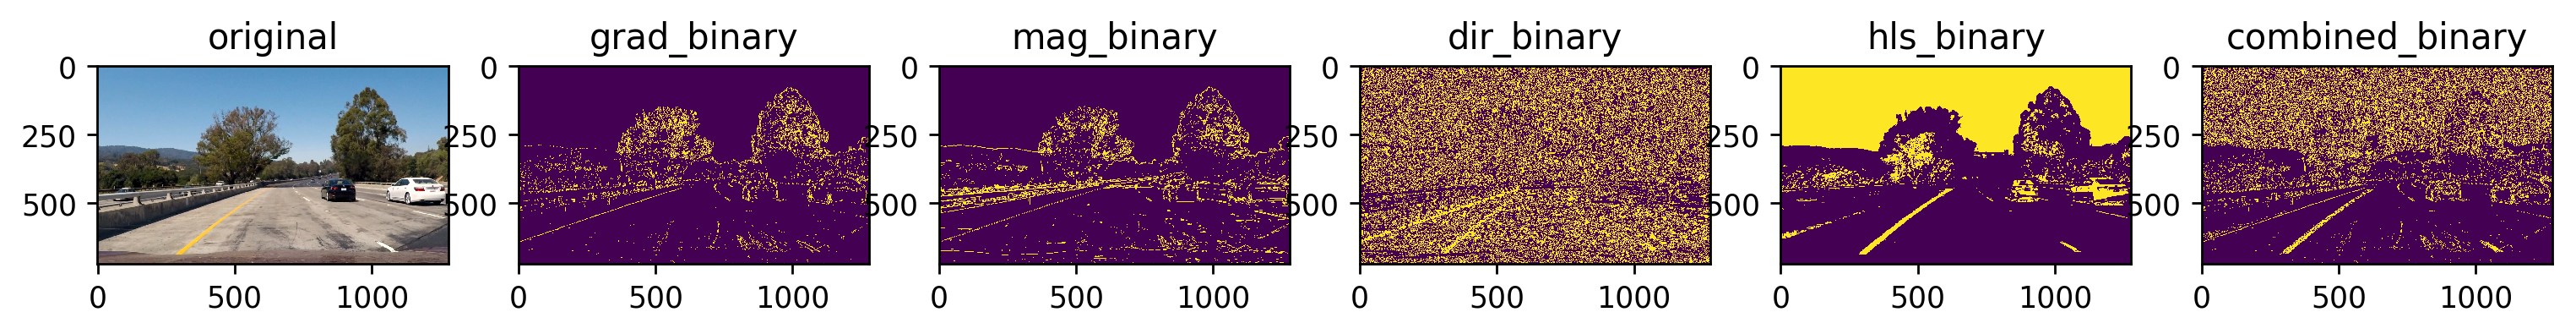

In [40]:
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the result
    return binary_output

# Magnitude threshhold
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    return binary_output

# Color thresholds by S-channel of HLS
def hls_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

# Sample Image
img =  mpimg.imread('./test_images/test1.jpg')
# Run the function
grad_binary = abs_sobel_thresh(img, orient='x', thresh_min=20, thresh_max=100)
mag_binary = mag_thresh(img, sobel_kernel=3, mag_thresh=(30, 100))
dir_binary = dir_threshold(img, sobel_kernel=15, thresh=(0.7, 1.3))
hls_binary = hls_select(img, thresh=(90, 255))
# Combined threshold
combined = np.zeros_like(dir_binary)
combined[((grad_binary == 1) | (hls_binary == 1) & (dir_binary == 1))] = 1

# Show Sample Image & Threshold
plt.figure(figsize=(15,7), dpi=250)
plt.subplot(1,6, 1)
plt.imshow(img)
plt.title('original')
plt.subplot(1,6, 2)
plt.imshow(grad_binary)
plt.title('grad_binary')
plt.subplot(1,6, 3)
plt.title('mag_binary')
plt.imshow(mag_binary)
plt.subplot(1,6, 4)
plt.title('dir_binary')
plt.imshow(dir_binary)
plt.subplot(1,6, 5)
plt.title('hls_binary')
plt.imshow(hls_binary)
plt.subplot(1,6, 6)
plt.title('combined_binary')
plt.imshow(combined)



## Perspective Transform

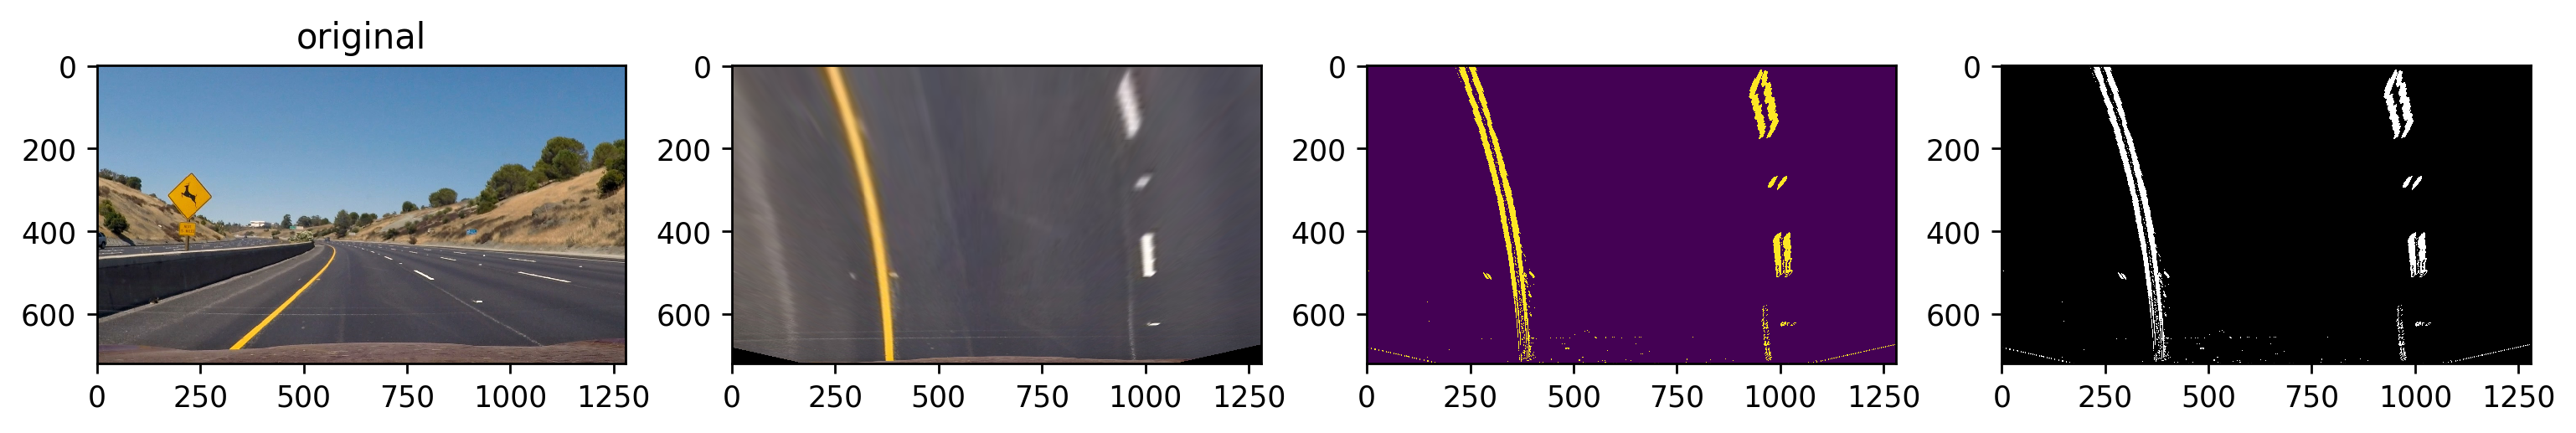

In [41]:
def thresh_pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    grad_binary = abs_sobel_thresh(img, orient='x', thresh_min=20, thresh_max=100)
    dir_binary = dir_threshold(img, sobel_kernel=15, thresh=(0.7, 1.3))
    hls_binary = hls_select(img, thresh=(90, 255))
    # Combined threshold
    combined = np.zeros_like(dir_binary)
    combined[((grad_binary == 1) | (hls_binary == 1) & (dir_binary == 1))] = 1
    return combined
    
result = thresh_pipeline(img)

# Sample Image
img =  mpimg.imread('./test_images/test2.jpg')
# Run the function
warped = warper(img, nx, ny)
combined = thresh_pipeline(warped, s_thresh=(170, 255), sx_thresh=(20, 100))
out_img = np.dstack((combined, combined, combined))

# Show Sample Image & Threshold
plt.figure(figsize=(15,7), dpi=250)
plt.subplot(1,4, 1)
plt.imshow(img)
plt.title('original')
plt.subplot(1,4, 2)
plt.imshow(warped)
plt.subplot(1,4, 3)
plt.imshow(combined)
plt.subplot(1,4, 4)
plt.imshow(out_img)

(720, 0)

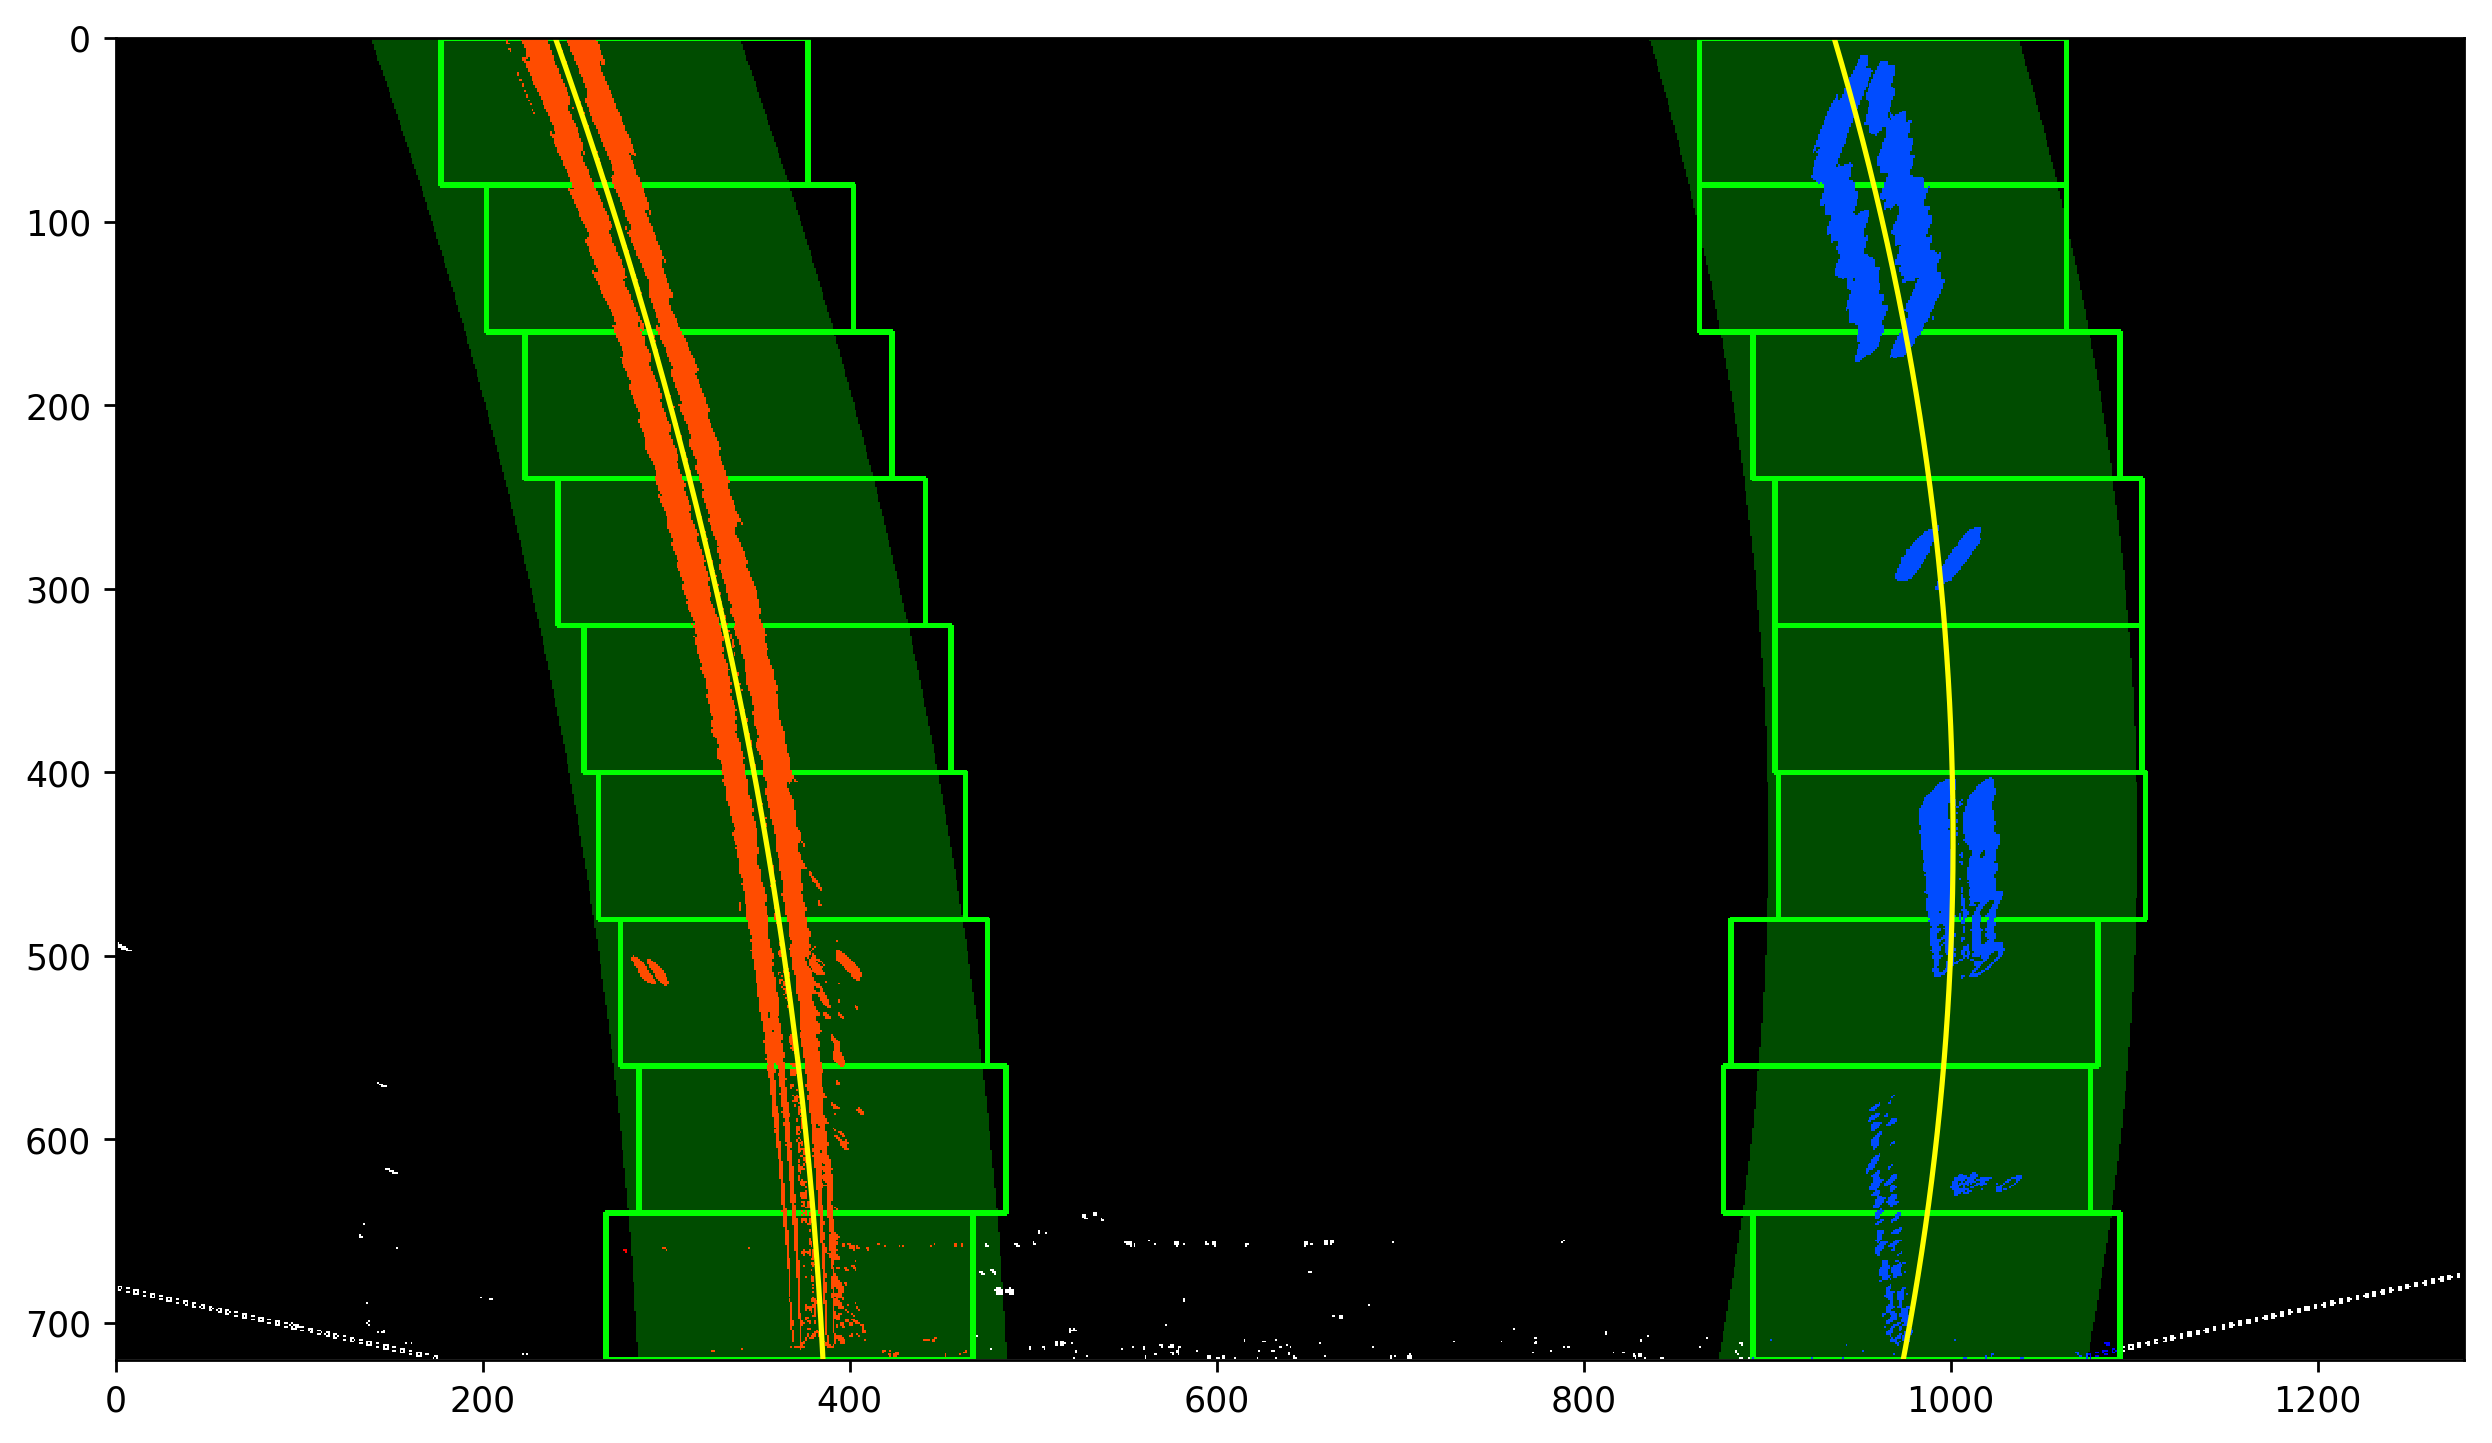

In [42]:
def detect_lane_line(binary_warped):
    bottom_half = np.int(binary_warped.shape[0]/2)

    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[bottom_half:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = 255*np.dstack((binary_warped, binary_warped, binary_warped)).astype('uint8')

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9

    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high), (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high), (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]


    # Create an image to draw on and an image to show the selection window
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    test_img = np.copy(out_img)
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

    return result, left_fitx, right_fitx, ploty, lefty, leftx, righty, rightx

result, left_fitx, right_fitx, ploty, lefty, leftx, righty, rightx = detect_lane_line(combined)

plt.figure(figsize=(15,7), dpi=250)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [43]:
def measure_curvature(ploty, lefty, leftx, righty, rightx):
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

    return left_curverad, right_curverad

left_curverad, right_curverad = measure_curvature(ploty, lefty, leftx, righty, rightx)
    
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')
# Example values: 632.1 m    626.2 m

773.561616934 m 484.714827974 m


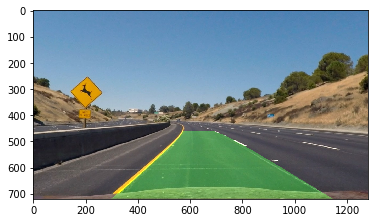

In [44]:
def on_the_original(img, binary_warped, ploty, leftx, lefty, rightx, righty):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    
    # Fit a second order polynomial to pixel positions in each fake lane line
    left_fit = np.polyfit(lefty, leftx, 2)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fit = np.polyfit(righty, rightx, 2)
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)

    return result

result = on_the_original(img, combined, ploty, leftx, lefty, rightx, righty)

plt.imshow(result)

## Video

In [45]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        
        

In [46]:
def video_pipeline(img):    
    warped = warper(img, nx, ny)
    combined = thresh_pipeline(warped, s_thresh=(170, 255), sx_thresh=(20, 100))
    result, left_fitx, right_fitx, ploty, lefty, leftx, righty, rightx = detect_lane_line(combined)
    left_curverad, right_curverad = measure_curvature(ploty, lefty, leftx, righty, rightx)
    result = on_the_original(img, combined, ploty, leftx, lefty, rightx, righty)
    
    gap_center = (img_size[0]/2- np.mean(right_fitx - left_fitx))*3.7/700
    text1 = 'Radius of Curvature = ' + str(np.int((left_curverad + right_curverad)/2))
    text2 = 'Vehicle is ' + str(np.round(gap_center,2)) + 'm left of center'
    cv2.putText(result, text1, (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 1, 4)
    cv2.putText(result, text2, (50, 85), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 1, 4)
    return result

In [ ]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

white_output = 'test.mp4'
clip1 = VideoFileClip('./project_video.mp4')
white_clip = clip1.fl_image(video_pipeline) 
%time white_clip.write_videofile(white_output, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

[MoviePy] >>>> Building video test.mp4
[MoviePy] Writing video test.mp4



 10%|▉         | 122/1261 [00:34<05:19,  3.56it/s]